# recurrent neural network (RNN)

In [8]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [9]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)
    
print(torch.__version__)
print(np.__version__)

2.0.0+cu117
1.26.4


In [10]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


## dataset

In [11]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)
# df4 = pd.read_csv('/home/yuan/results/epitope/shuffle.txt', sep='\t', header=None, index_col=None)

In [12]:
# drop duplicates
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)

df21 = df2.drop_duplicates()
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
(3185991, 2) (3185991, 2)
(1863999, 2) (1863998, 2)


In [13]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(6915231, 2)


,0,1
21647,GMAALPRLIAFTSEHSHFSL,epitope
2636856,LSDVCDVPT,other
468989,YFINCEWAFGQREP,random
211372,DGGQKPEGE,other
1478315,LETTNFKVE,other


In [14]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('epitope', 'GMAALPRLIAFTSEHSHFSL')
Counter({'other': 3185991, 'epitope': 1865242, 'random': 1863998})


In [15]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('random', 'NRCNQWEKREQRFQIEITD')
split data:  4149138 1383046 1383047

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: PDGTNHQQLVVDAGISADMD ['P', 'D', 'G', 'T', 'N', 'H', 'Q', 'Q', 'L', 'V', 'V', 'D', 'A', 'G', 'I', 'S', 'A', 'D', 'M', 'D']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 4043485), ('S', 3438374), ('A', 3407159), ('G', 3180652), ('E', 3157476), ('V', 3022572), ('P', 2813102), ('K', 2789705), ('T', 2686107), ('R', 2661014), ('D', 2552652), ('I', 2364154), ('Q', 2292287), ('N', 2113328), ('F', 2029282), ('Y', 1745225), ('H', 1557243), ('M', 1426512), ('C', 1398606), ('W', 1146170), ('X', 3127), ('U', 72), ('B', 45), ('Z', 44), ('J', 6)])
counts of input: [1912066, 1118557, 1118515]

## Step 3 encoding: encoding each unique token into integers...


In [16]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [7]:
import torch
import numpy as np

# Create a PyTorch tensor
tensor = torch.tensor([1, 2, 3])

# Convert the tensor to a NumPy array
numpy_array = tensor.numpy().astype(int)

print(type(numpy_array))

<class 'numpy.ndarray'>


In [17]:
num_epochs = 10
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.7972 val_acc: 0.8061, val_recall: 0.7311
Epoch 1 acc: 0.8078 val_acc: 0.8086, val_recall: 0.7263
Epoch 2 acc: 0.8106 val_acc: 0.8088, val_recall: 0.7169
Epoch 3 acc: 0.8119 val_acc: 0.8113, val_recall: 0.7236
Epoch 4 acc: 0.8136 val_acc: 0.8114, val_recall: 0.7376
Epoch 5 acc: 0.8114 val_acc: 0.8119, val_recall: 0.7300
Epoch 6 acc: 0.8134 val_acc: 0.8070, val_recall: 0.7367
Epoch 7 acc: 0.8135 val_acc: 0.8114, val_recall: 0.7345
Epoch 8 acc: 0.8146 val_acc: 0.8081, val_recall: 0.7289
Epoch 9 acc: 0.8132 val_acc: 0.8073, val_recall: 0.7263


In [ ]:
stat

In [ ]:
# test predict
input = [
    # epitope
    'SSPFLKGFLAGYVVAKLRASAV', 
    # other seq
    'AELMPVGDNN',
    # wrong seq
    'AXAXAXAXA'
]
res = p.predict(input)
res

In [ ]:
print(trained_model.embedding)
print(trained_model.embedding.weight.shape)

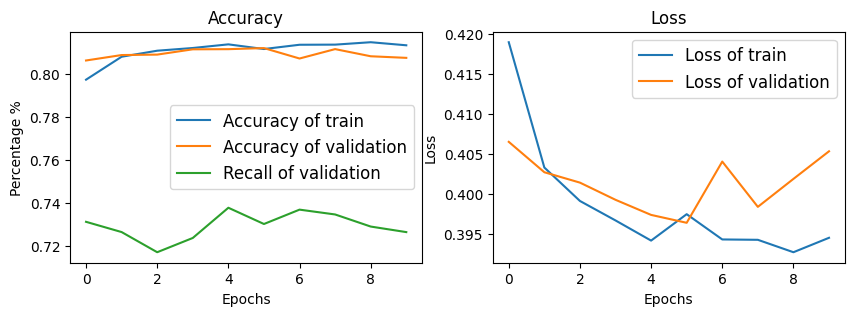

In [18]:
fig = plt.figure(figsize=(10,3))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Accuracy of train")
ax.plot(x_arr, stat.acc_valid, label="Accuracy of validation")
ax.plot(x_arr, stat.rec_valid, label="Recall of validation")
ax.legend(fontsize=12)
# ax.set_ylim(.8, 1)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage %')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Loss of train")
ax.plot(x_arr, stat.loss_valid, label="Loss of validation")
ax.legend(fontsize=12)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

In [131]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.7441317809743757,
 'accuracy': 0.8144922045310101,
 'loss': 0.3923020526516849}

In [132]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,SHSMRYFDTAVSR,0.739259,epitope
1,GIQYLRDY,0.287142,epitope
2,SRFCRGVPDA,0.061234,other
3,QEDAFFASQ,0.026200,other
4,AKTVSYDFRMWVSS,0.075150,random


372572 1010475


Text(0.5, 1.0, 'Distinguish non-epitopes, n = 1010475')

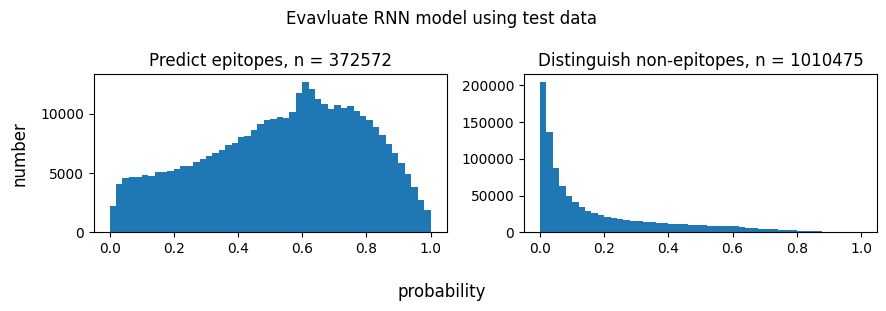

In [134]:
t = pred_test[pred_test['labels']=='epitope']['predict']
f = pred_test[~(pred_test['labels']=='epitope')]['predict']
print(len(t), len(f))

fig, ax = plt.subplots(1, 2, figsize=(9,3), layout='tight')
fig.suptitle('Evavluate RNN model using test data')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, bins=50)
ax[0].set_title(f'Predict epitopes, n = {len(t)}')
ax[1].hist(f, bins=50)
ax[1].set_title(f'Distinguish non-epitopes, n = {len(f)}')

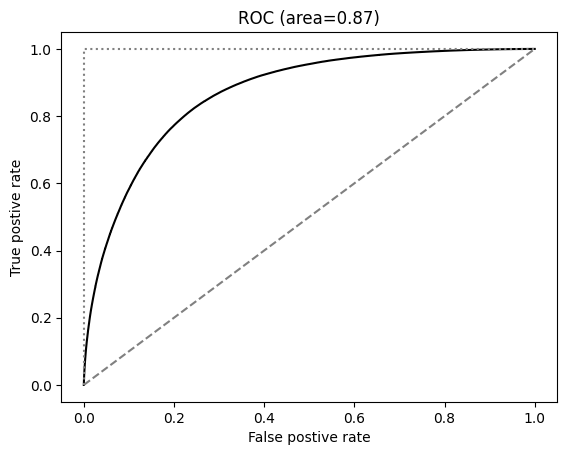

In [144]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(pred_test['labels'], pred_test['predict'], pos_label='epitope')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='black')
plt.title(f'ROC (area={roc_auc:.2f})')
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.plot([0,0,1],[0,1,1], linestyle=':', color='grey')

In [147]:
# save model
torch.save(input_vocab, '../models/epitopes_rnn_vocab.pth')
torch.save(model.state_dict(), '../models/epitopes_rnn_20.pth')